<a href="https://colab.research.google.com/github/azam123/ecommerce-case-study-/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

customers_df = pd.read_excel("/content/Sacaler EDA /CustomersData.xlsx")
sales_df = pd.read_csv("/content/Sacaler EDA /Online_Sales.csv")
coupon_df = pd.read_csv("/content/Sacaler EDA /Discount_Coupon.csv")
tax_df = pd.read_excel("/content/Sacaler EDA /Tax_amount.xlsx")
marketing_df = pd.read_csv("/content/Sacaler EDA /Marketing_Spend.csv")

**Starting Analysis**

In [16]:
# Preprocess Dates
sales_df['Transaction_Date'] = pd.to_datetime(sales_df['Transaction_Date'])
marketing_df['Date'] = pd.to_datetime(marketing_df['Date'])

sales_df['Month'] = sales_df['Transaction_Date'].dt.strftime('%b')
sales_df['Year'] = sales_df['Transaction_Date'].dt.year

# Merge DataFrames
df = pd.merge(sales_df, customers_df, on='CustomerID', how='left')
df = pd.merge(df, tax_df, on='Product_Category', how='left')
df = pd.merge(df, coupon_df, on=['Month', 'Product_Category'], how='left')

# Calculate Financial Metrics
df['Revenue'] = df['Quantity'] * df['Avg_Price']
df['Discount_pct'] = df.apply(lambda row: 0 if row['Coupon_Status'] == 'Not Used' else row['Discount_pct'], axis=1)
df['Discount'] = df['Revenue'] * (df['Discount_pct'].fillna(0) / 100)
df['Tax'] = df['Revenue'] * df['GST'].fillna(0)
df['Net_Revenue'] = df['Revenue'] + df['Delivery_Charges'] - df['Discount'] - df['Tax']

# EDA: Revenue Trends
monthly_revenue = df.groupby(df['Transaction_Date'].dt.to_period('M')).agg({'Net_Revenue': 'sum'}).reset_index()
monthly_revenue['Transaction_Date'] = monthly_revenue['Transaction_Date'].astype(str)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_revenue, x='Transaction_Date', y='Net_Revenue')
plt.title('Monthly Net Revenue Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



**Calculate Financial Metrics**

In [17]:
# Calculate Financial Metrics
df['Revenue'] = df['Quantity'] * df['Avg_Price']
df['Discount_pct'] = df.apply(lambda row: 0 if row['Coupon_Status'] == 'Not Used' else row['Discount_pct'], axis=1)
df['Discount'] = df['Revenue'] * (df['Discount_pct'].fillna(0) / 100)
df['Tax'] = df['Revenue'] * df['GST'].fillna(0)
df['Net_Revenue'] = df['Revenue'] + df['Delivery_Charges'] - df['Discount'] - df['Tax']


**EDA  Revenue Trends**

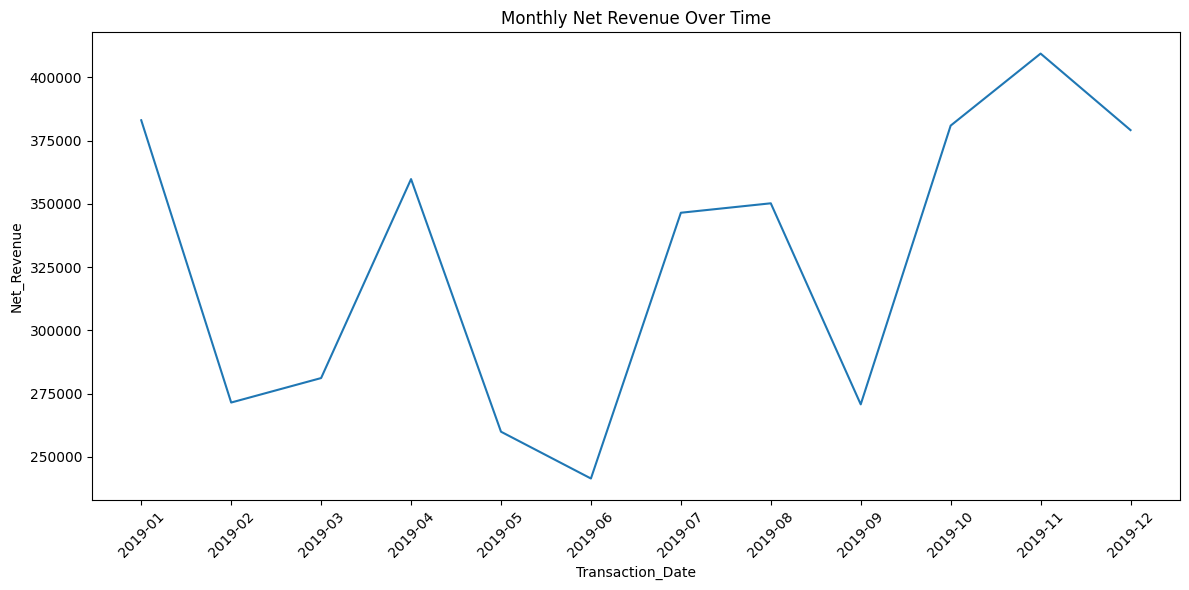

In [18]:
# EDA: Revenue Trends
monthly_revenue = df.groupby(df['Transaction_Date'].dt.to_period('M')).agg({'Net_Revenue': 'sum'}).reset_index()
monthly_revenue['Transaction_Date'] = monthly_revenue['Transaction_Date'].astype(str)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_revenue, x='Transaction_Date', y='Net_Revenue')
plt.title('Monthly Net Revenue Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

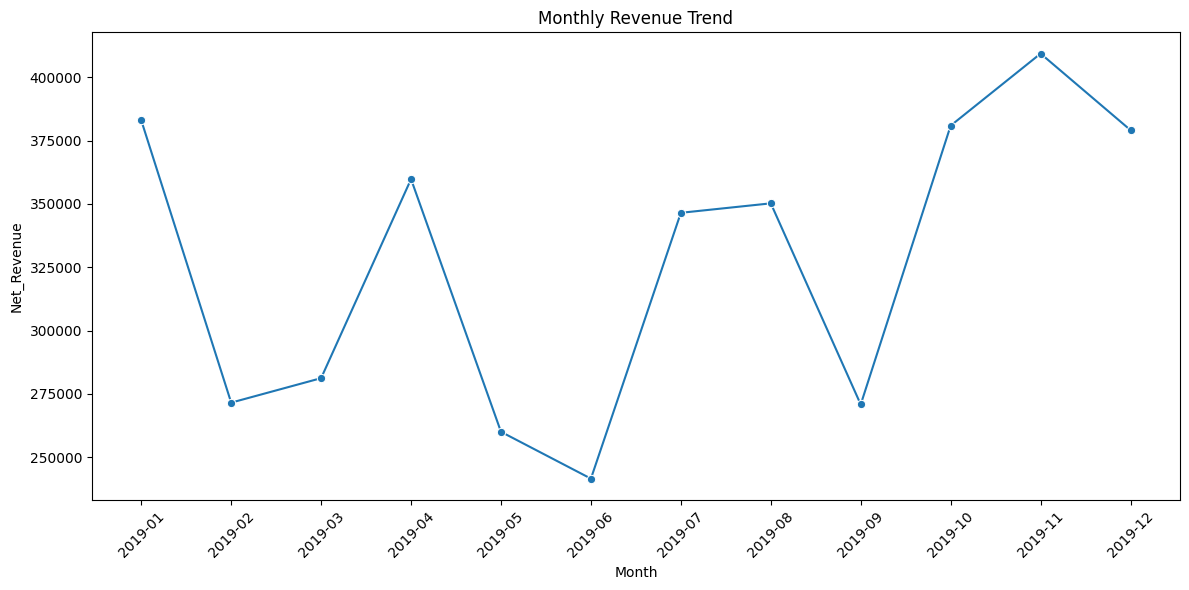

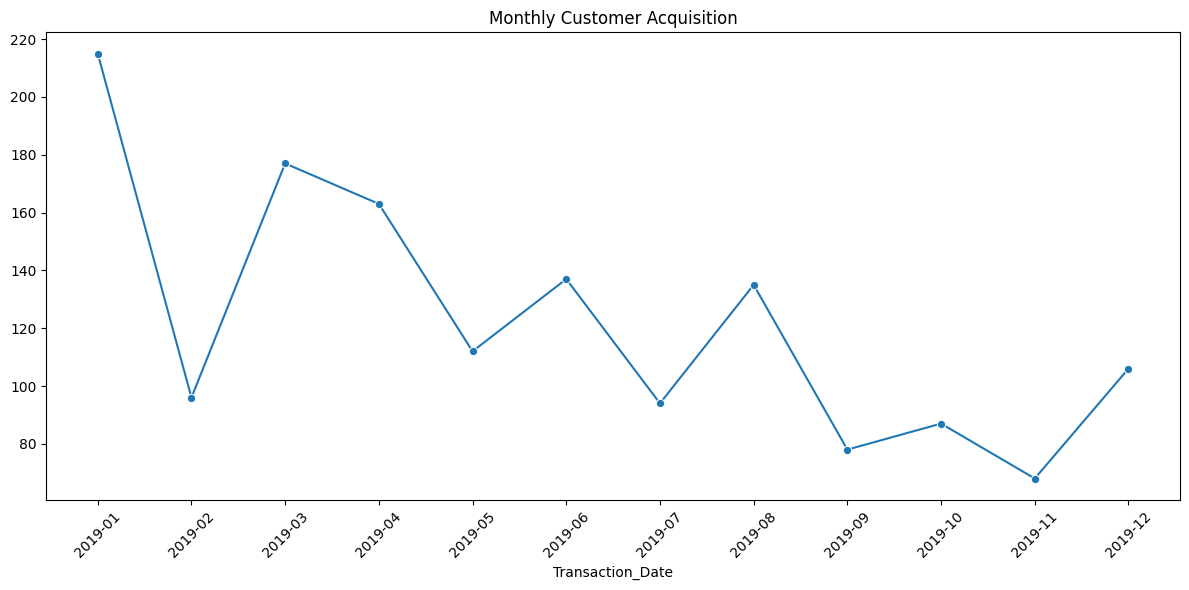

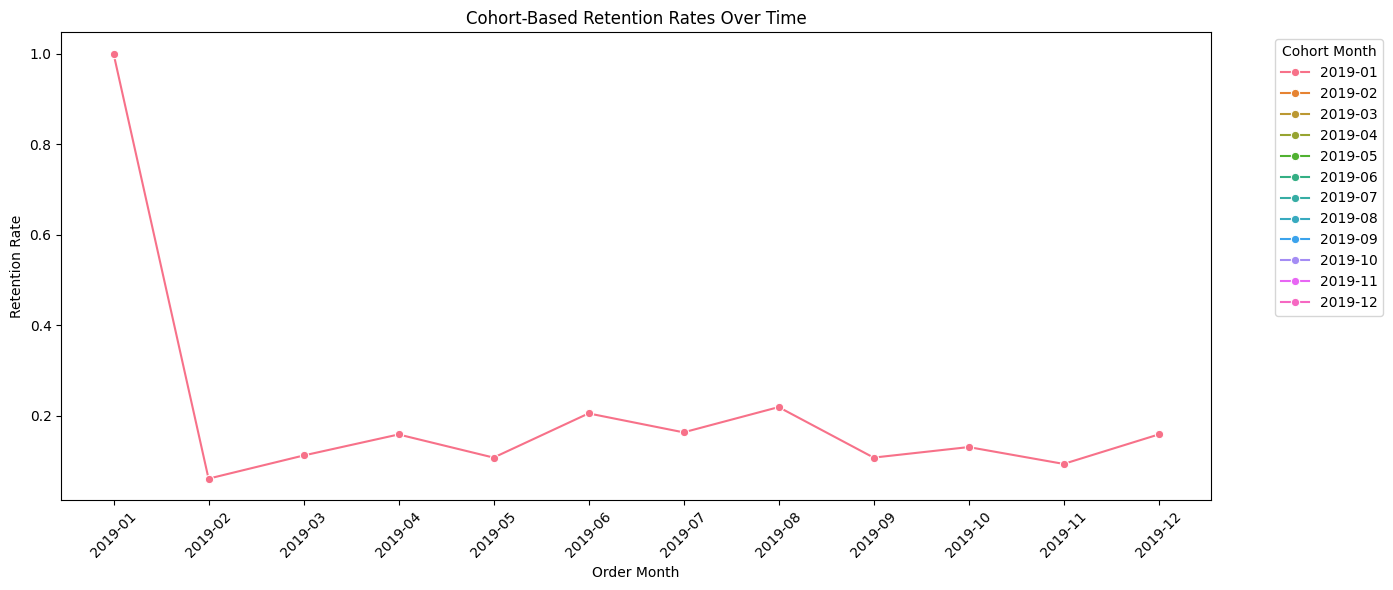

/tmp/ipython-input-27-1393532079.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_revenue.values, y=category_revenue.index, palette="Blues_d")


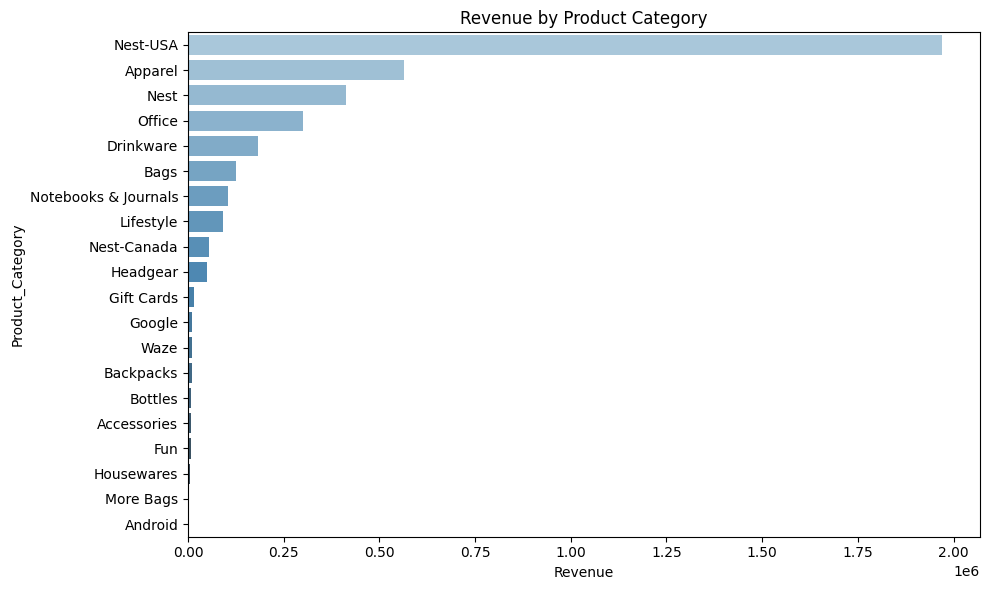

/tmp/ipython-input-27-1393532079.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_revenue = rfm_df.groupby('Segment')['Monetary'].sum().sort_values()
/tmp/ipython-input-27-1393532079.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_revenue.index, y=segment_revenue.values, palette='viridis')


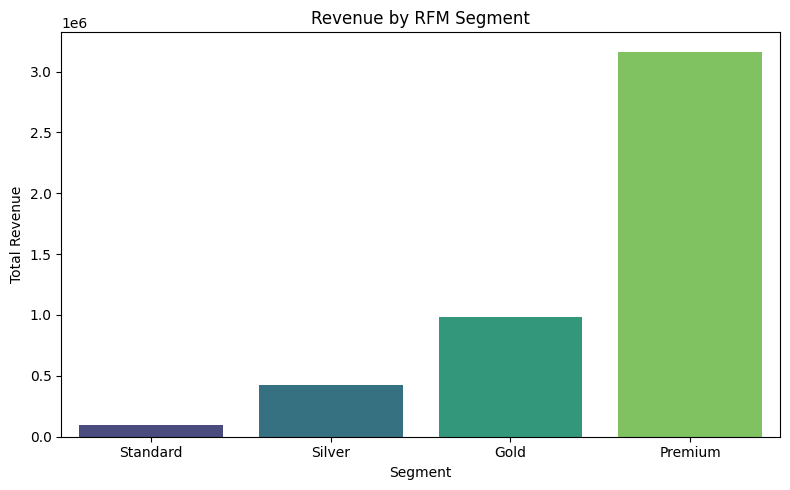

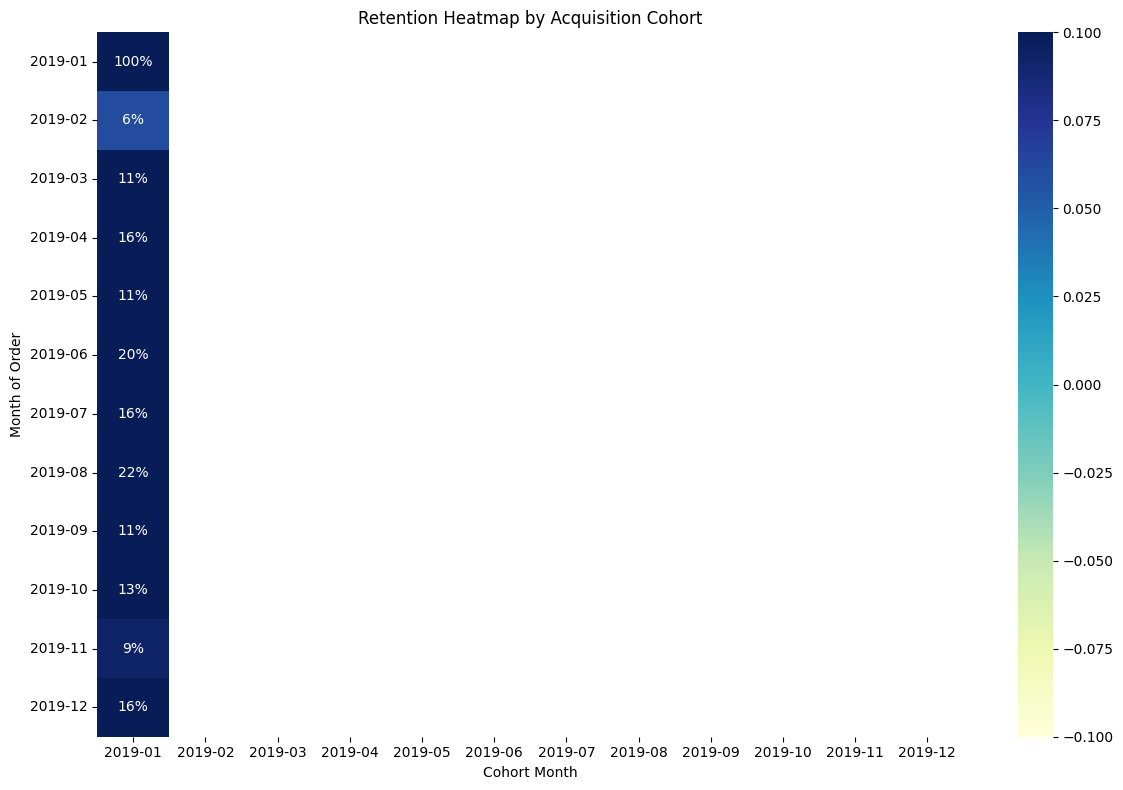

/tmp/ipython-input-27-1393532079.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Coupon_Status', y='AOV', palette='pastel')


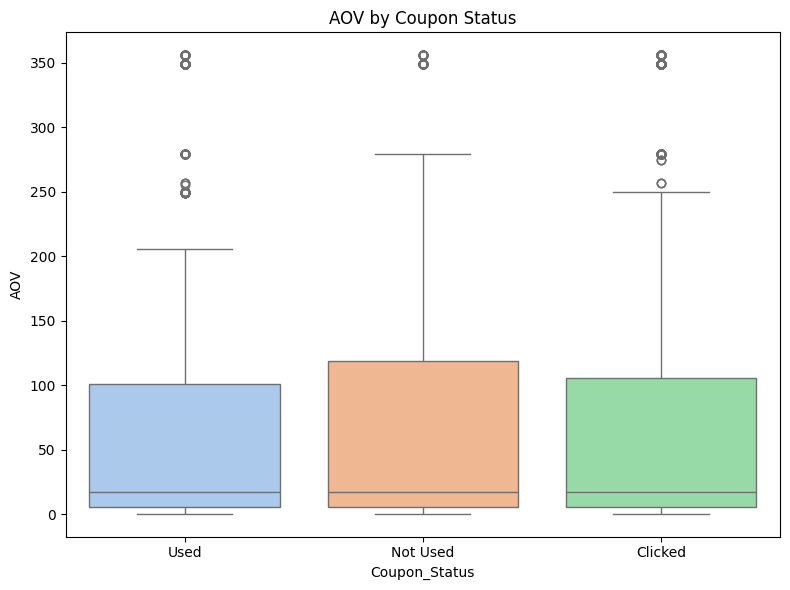

/tmp/ipython-input-27-1393532079.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Delivery_Tier', y='AOV', palette='Set2')


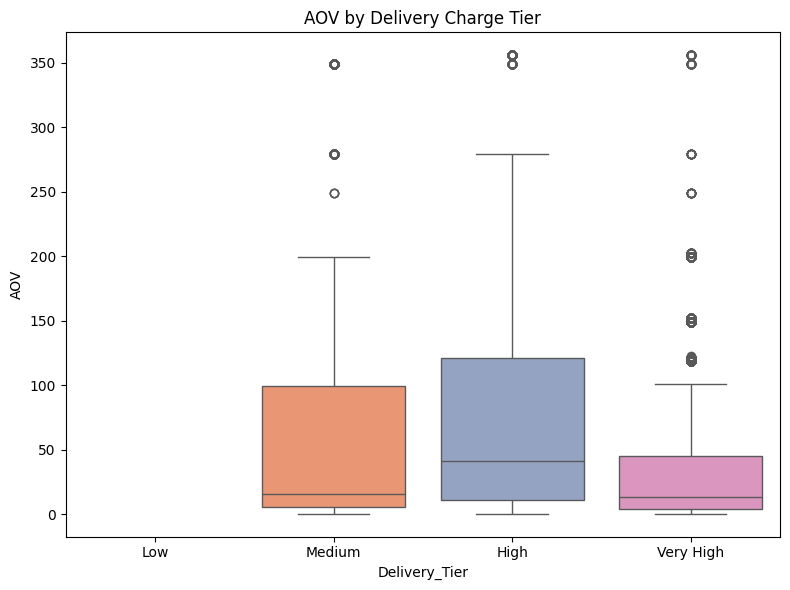

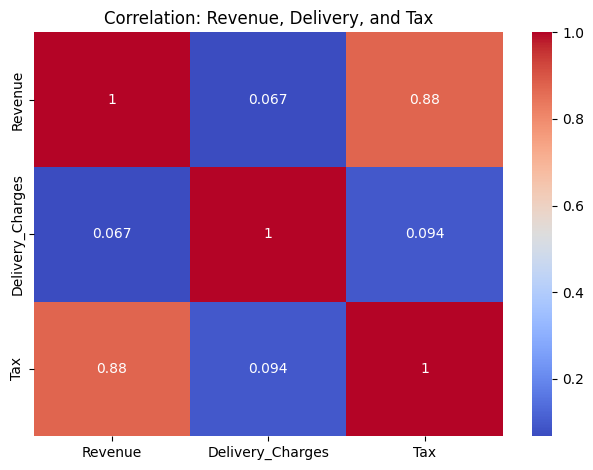

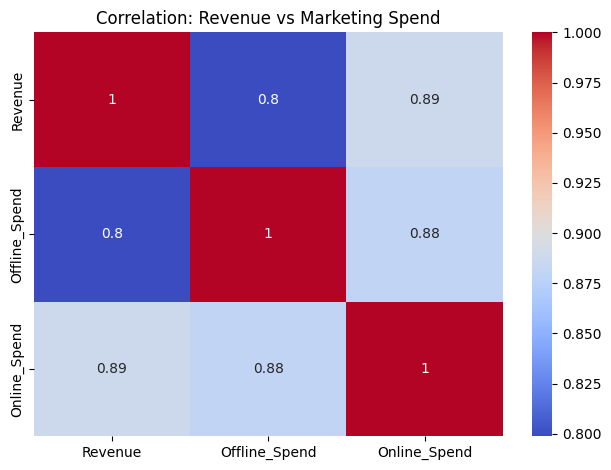

In [27]:
### ✅ 1. **Line Charts: Monthly Revenue Trends, Acquisition, and Retention**

import matplotlib.pyplot as plt
import seaborn as sns

# Revenue per month
df['Month'] = df['Transaction_Date'].dt.to_period('M')
monthly_revenue = df.groupby('Month')['Net_Revenue'].sum().reset_index()
monthly_revenue['Month'] = monthly_revenue['Month'].astype(str)  # 👈 fix

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_revenue, x='Month', y='Net_Revenue', marker='o')
plt.title("Monthly Revenue Trend")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Acquisition: first purchase per customer
first_purchase = df.groupby('CustomerID')['Transaction_Date'].min().dt.to_period('M')
acquisition = first_purchase.value_counts().sort_index()

plt.figure(figsize=(12,6))
sns.lineplot(x=acquisition.index.astype(str), y=acquisition.values, marker='o')
plt.title("Monthly Customer Acquisition")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create cohort labels
df['FirstPurchaseMonth'] = df.groupby('CustomerID')['Transaction_Date'].transform('min').dt.to_period('M')
df['OrderMonth'] = df['Transaction_Date'].dt.to_period('M')

# Pivot: Number of unique customers per cohort per month
cohort = df.groupby(['OrderMonth', 'FirstPurchaseMonth'])['CustomerID'].nunique().unstack(fill_value=0)

# Calculate retention: divide each column by its cohort size
cohort_percent = cohort.divide(cohort.iloc[0], axis=1)

# Fix: convert Periods to strings for plotting
cohort_percent.index = cohort_percent.index.astype(str)
cohort_percent.columns = cohort_percent.columns.astype(str)

# Melt to long format
cohort_long = cohort_percent.reset_index().melt(id_vars='OrderMonth', var_name='CohortMonth', value_name='Retention')
cohort_long.rename(columns={'OrderMonth': 'Month'}, inplace=True)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=cohort_long, x='Month', y='Retention', hue='CohortMonth', marker='o')
plt.title("Cohort-Based Retention Rates Over Time")
plt.ylabel("Retention Rate")
plt.xlabel("Order Month")
plt.xticks(rotation=45)
plt.legend(title='Cohort Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 2. **Bar Charts: Product Category Performance, RFM Segment Revenue**

# Top product categories by revenue
category_revenue = df.groupby('Product_Category')['Net_Revenue'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=category_revenue.values, y=category_revenue.index, palette="Blues_d")
plt.title("Revenue by Product Category")
plt.xlabel("Revenue")
plt.tight_layout()
plt.show()

# RFM Segment Revenue (assuming rfm_df is precomputed with segment labels)
rfm_df = df.groupby('CustomerID').agg({
    'Transaction_Date': lambda x: (df['Transaction_Date'].max() - x.max()).days,
    'Transaction_ID': 'nunique',
    'Revenue': 'sum'
}).rename(columns={'Transaction_Date': 'Recency', 'Transaction_ID': 'Frequency', 'Revenue': 'Monetary'})

# Simple segmentation
rfm_df['Segment'] = pd.qcut(rfm_df['Monetary'], 4, labels=['Standard', 'Silver', 'Gold', 'Premium'])
segment_revenue = rfm_df.groupby('Segment')['Monetary'].sum().sort_values()

plt.figure(figsize=(8,5))
sns.barplot(x=segment_revenue.index, y=segment_revenue.values, palette='viridis')
plt.title("Revenue by RFM Segment")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()

### 3. **Heatmap: Retention by Cohort**

# Retention heatmap (reuse cohort data)
plt.figure(figsize=(12,8))
sns.heatmap(cohort_percent, annot=True, fmt='.0%', cmap="YlGnBu")
plt.title("Retention Heatmap by Acquisition Cohort")
plt.xlabel("Cohort Month")
plt.ylabel("Month of Order")
plt.tight_layout()
plt.show()


### 4. **Boxplots: AOV by Coupon Usage & Delivery Tiers**

# AOV = Revenue / Order
df['AOV'] = df['Revenue'] / df['Quantity']

plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='Coupon_Status', y='AOV', palette='pastel')
plt.title("AOV by Coupon Status")
plt.tight_layout()
plt.show()

# Delivery Tier boxplot
df['Delivery_Tier'] = pd.cut(df['Delivery_Charges'], bins=[0, 3, 6, 10, 20], labels=['Low', 'Medium', 'High', 'Very High'])

plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='Delivery_Tier', y='AOV', palette='Set2')
plt.title("AOV by Delivery Charge Tier")
plt.tight_layout()
plt.show()


### 5. **Correlation Plots: Revenue vs Delivery Charges, Marketing Spend**

# Delivery Charges correlation
corr_vars = df[['Revenue', 'Delivery_Charges', 'Tax']]
sns.heatmap(corr_vars.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation: Revenue, Delivery, and Tax")
plt.tight_layout()
plt.show()

# Monthly correlation with marketing
monthly_df = df.groupby(df['Transaction_Date'].dt.to_period('M'))['Revenue'].sum().reset_index()
monthly_mkt = marketing_df.groupby(marketing_df['Date'].dt.to_period('M'))[['Offline_Spend', 'Online_Spend']].sum().reset_index()

monthly_combined = pd.merge(monthly_df, monthly_mkt, left_on='Transaction_Date', right_on='Date')

sns.heatmap(monthly_combined[['Revenue', 'Offline_Spend', 'Online_Spend']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation: Revenue vs Marketing Spend")
plt.tight_layout()
plt.show()
